In [1]:
import csv

condition_mapping_file = "./resources/CCSCM.csv"
procedure_mapping_file = "./resources/CCSPROC.csv"
drug_file = "./resources/ATC.csv"

condition_dict = {}
with open(condition_mapping_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        condition_dict[row['code']] = row['name'].lower()

procedure_dict = {}
with open(procedure_mapping_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        procedure_dict[row['code']] = row['name'].lower()

drug_dict = {}
with open(drug_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['level'] == '3.0':
            drug_dict[row['code']] = row['name'].lower()

In [2]:
from pyhealth.datasets import MIMIC3Dataset
from GraphCare.task_fn import mortality_prediction_mimic3_fn, readmission_prediction_mimic3_fn

mimic3_ds = MIMIC3Dataset(
    root="../../../data/physionet.org/files/mimiciii/1.4/", 
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],      
    code_mapping={
        "NDC": ("ATC", {"target_kwargs": {"level": 3}}),
        "ICD9CM": "CCSCM",
        "ICD9PROC": "CCSPROC"
        },
)

sample_dataset = mimic3_ds.set_task(readmission_prediction_mimic3_fn)
# sample_dataset = mimic3_ds.set_task(readmission_prediction_mimic3_fn)
# sample_dataset = mimic3_ds.set_task(length_of_stay_prediction_mimic3_fn)

/home/pj20/miniconda3/envs/kgc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating samples for readmission_prediction_mimic3_fn: 100%|██████████| 46520/46520 [00:00<00:00, 103495.17it/s]


In [3]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [4]:
import json
import pickle
from tqdm import tqdm
import numpy as np
import networkx as nx

# with open('./exp_data/ccscm_ccsproc_atc5/sample_dataset_mortality.pkl', 'rb') as f:
#     sample_dataset= pickle.load(f)
with open('./graphs/cond_proc_drug/CCSCM_CCSPROC_ATC3/ent2id.json', 'r') as file:
    ent2id = json.load(file)
with open('./graphs/cond_proc_drug/CCSCM_CCSPROC_ATC3/rel2id.json', 'r') as file:
    rel2id = json.load(file)
with open('./graphs/cond_proc_drug/CCSCM_CCSPROC_ATC3/entity_embedding.pkl', 'rb') as file:
    ent_emb = pickle.load(file)

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score

# perform DBSCAN clustering with the best parameters
clustering = DBSCAN(eps=0.07, min_samples=1, metric='cosine').fit(ent_emb)

In [5]:
from sklearn.cluster import AgglomerativeClustering

# Set up the hierarchical clustering algorithm
cluster_alg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.15, linkage='average', affinity='cosine')
# Fit the algorithm to your data
cluster_labels = cluster_alg.fit_predict(ent_emb)

/home/pj20/miniconda3/envs/kgc/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [6]:
from collections import defaultdict
import json

def nested_dict():
    return defaultdict(list)

map_cluster = defaultdict(nested_dict)

for unique_l in np.unique(cluster_labels):
    for cur in range(len(cluster_labels)):
        if cluster_labels[cur] == unique_l:
            map_cluster[str(unique_l)]['nodes'].append(cur)

# map_cluster = defaultdict(nested_dict)
# i = 0
# for key in map_cluster_.keys():
#     if len(map_cluster_[key]['nodes']) > 100:
#         for node in map_cluster_[key]['nodes']:
#             map_cluster[str(i)]['nodes'] = [node]
#             i+=1
#     else:
#         map_cluster[str(i)]['nodes'] = map_cluster_[key]['nodes']
#         i+=1

for unique_l in map_cluster.keys():
    nodes = map_cluster[unique_l]['nodes']
    nodes = np.array(nodes)
    embedding_mean = np.mean(ent_emb[nodes], axis=0)
    map_cluster[unique_l]['embedding'].append(embedding_mean.tolist())

map_cluster_inv = {}
for cluster_label, item in map_cluster.items():
    for node in item['nodes']:
        map_cluster_inv[str(node)] = cluster_label

In [7]:
len(map_cluster), len(ent_emb)

(4599, 42056)

In [8]:
with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/clusters_th015.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster, f, indent=6)

with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/clusters_inv_th015.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster_inv, f, indent=6)

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

np.random.seed(528)

# Select 500 random rows from ent_emb
sample_indices = np.random.choice(ent_emb.shape[0], size=3000, replace=False)
sample_ent_emb = ent_emb[sample_indices, :]
sample_cluster_labels = cluster_labels[sample_indices]

# Compute the t-SNE projection of the embeddings
tsne = TSNE(n_components=2, perplexity=30,random_state=528)
embeddings_2d = tsne.fit_transform(sample_ent_emb)

cluster_emb = []
# Plot the cluster centers, colored by cluster label
for cluster_label in range(len(map_cluster)):
    cluster_emb.append(np.array(map_cluster[str(cluster_label)]['embedding'][0]))

cluster_embedding_2d = tsne.fit_transform(np.array(cluster_emb))


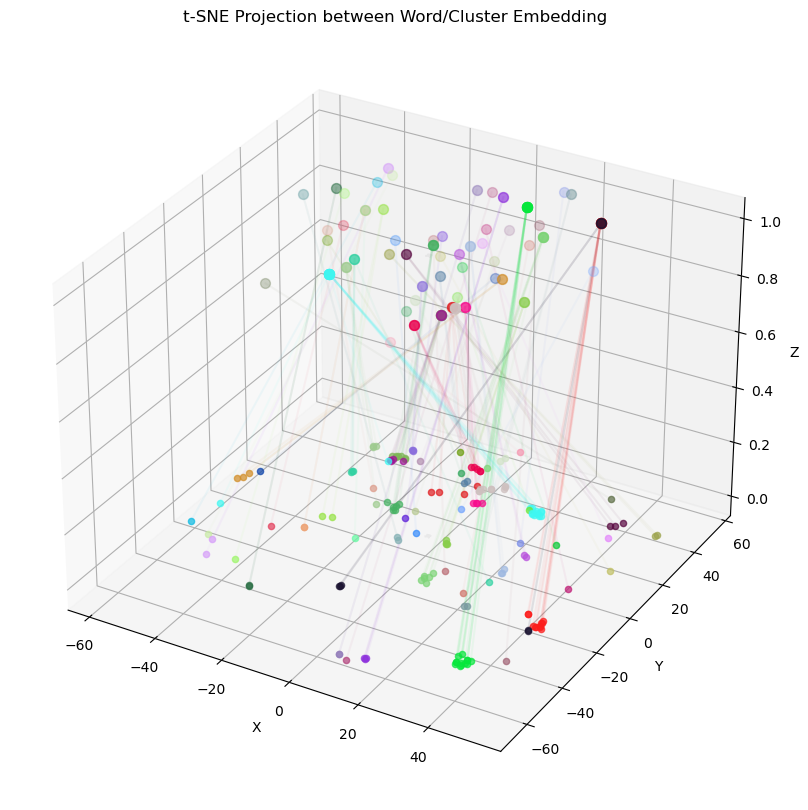

In [10]:
import matplotlib.colors as mcolors
from matplotlib.cm import Paired
import random
import seaborn as sns

# Function to generate a random HEX color
def generate_hex_color():
    hex_digits = '0123456789ABCDEF'
    color = '#' + ''.join(random.choice(hex_digits) for _ in range(6))
    return color

comfortable_colors = sns.color_palette('bright', 30).as_hex()

# Define the projection plane coordinates
plane1_coords = np.array([[1, 0, 0], [0, 1, 0], [1, 1, 0], [0, 0, 0]])
plane2_coords = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 1], [0, 0, 1]])

# Create a custom colormap using the Paired colormap
colors = {}
for i, label in enumerate(sample_cluster_labels):
    colors[label] = generate_hex_color()

# Create a single 3D subplot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the embeddings on the first plane
for i, label in enumerate(sample_cluster_labels):
    if label < 80:
        ax.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 0, c=colors[label], alpha=0.7)
        ax.scatter(cluster_embedding_2d[label, 0], cluster_embedding_2d[label, 1], 1, s=50, c=colors[label], alpha=0.3)
        ax.plot([embeddings_2d[i, 0], cluster_embedding_2d[label, 0]],
                [embeddings_2d[i, 1], cluster_embedding_2d[label, 1]],
                [0, 1], c=colors[label], alpha=0.05)

# Plot the two planes
ax.plot(plane1_coords[:, 0], plane1_coords[:, 1], plane1_coords[:, 2], c='gray', alpha=0.1)
ax.plot(plane2_coords[:, 0], plane2_coords[:, 1], plane2_coords[:, 2], c='gray', alpha=0.1)

# Plot the projection line between the two planes
line_xs = [1, 0]
line_ys = [0, 1]
line_zs = [0, 1]

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('t-SNE Projection between Word/Cluster Embedding')

plt.savefig('clus_cpd_th015.pdf', format='pdf')

plt.show()


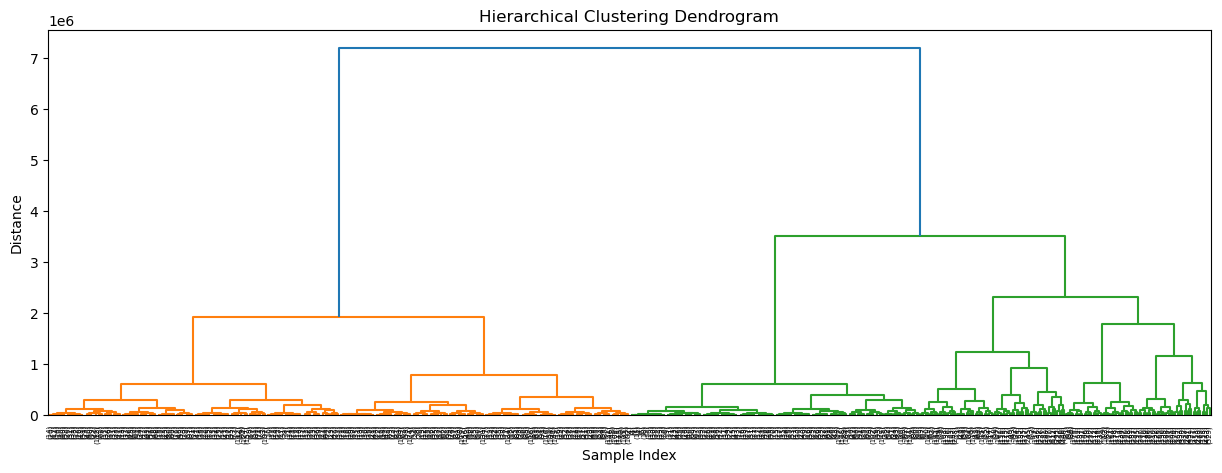

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Create the linkage matrix
Z = linkage(cluster_alg.children_, method='ward')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(15, 5))
dendrogram(Z, truncate_mode='level', p=8, ax=ax)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('tree_cpd_th015.pdf', format='pdf')
plt.show()


In [11]:
import json

with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/clusters_th015.json', 'r', encoding='utf-8') as f:
    map_cluster = json.load(f)

with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/clusters_inv_th015.json', 'r', encoding='utf-8') as f:
    map_cluster_inv = json.load(f)

In [12]:
G = nx.Graph()

for cluster_label, item in map_cluster.items():
    G.add_nodes_from([
        (int(cluster_label), {'y': int(cluster_label), 'x': item['embedding'][0]})
    ])

# for i in range(len(rel_emb)):
#     G.add_nodes_from([
#         (i+len(ent_emb), {'y': i+len(ent_emb), 'x': rel_emb[i]})
#     ])

triples_all = []
for patient in tqdm(sample_dataset):
    triples = []
    triple_set = set()
    # node_set = set()
    conditions = flatten(patient['conditions'])
    for condition in conditions:
        cond_file = f'./graphs/condition/CCSCM/{condition}.txt'
        with open(cond_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triples.append((int(map_cluster_inv[h]), int(map_cluster_inv[t])))
                    triple_set.add(triple)
                    # node_set.add(h)
                    # node_set.add(r)

    procedures = flatten(patient['procedures'])
    for procedure in procedures:
        proc_file = f'./graphs/procedure/CCSPROC/{procedure}.txt'
        with open(proc_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triples.append((int(map_cluster_inv[h]), int(map_cluster_inv[t])))
                    triple_set.add(triple)


    drugs = flatten(patient['drugs'])
    for drug in drugs:
        drug_file = f'./graphs/drug/ATC3/{drug}.txt'

        with open(drug_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triples.append((int(map_cluster_inv[h]), int(map_cluster_inv[t])))
                    triple_set.add(triple)

    G.add_edges_from(
        triples,
        # label=prepare_label(patient['drugs'])
    )
    
    # triples.append(prepare_label(patient['drugs']))
    # triples_all.append(np.array(triples))


100%|██████████| 9717/9717 [02:30<00:00, 64.37it/s]


In [13]:
import pickle

with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/graph_binary_readm_th015.pkl', 'wb') as f:
    pickle.dump(G, f)

In [14]:
from torch_geometric.utils import to_networkx, from_networkx
G_tg = from_networkx(G) 

In [15]:
import torch

c_v, p_v, d_v = [], [], []
for patient in sample_dataset:
    c_v.append(len(patient['conditions']))
    p_v.append(len(patient['procedures']))
    d_v.append(len(patient['drugs']))

print(max(c_v), max(p_v), max(d_v))
max_visits = max(c_v)

def pad_and_convert(visits, max_visits, max_nodes):
    padded_visits = []
    for visit in visits:
        visit_multi_hot = torch.zeros(max_nodes)
        for idx, med_code in enumerate(visit):
            visit_multi_hot[med_code] = 1
        padded_visits.append(visit_multi_hot)
    while len(padded_visits) < max_visits:
        padded_visits.append(torch.zeros(max_nodes))
    return torch.stack(padded_visits, dim=0)
        

for patient in tqdm(sample_dataset): 
    node_set_list_c = []
    node_set_list_p = []
    node_set_list_d = []
    node_set_all = set()

    for visit_i in range(len(patient['conditions'])):
        triple_set = set()
        node_set = set()  
        conditions = patient['conditions'][visit_i]
        procedures = patient['procedures'][visit_i]
        drugs = patient['drugs'][visit_i]
        
        for condition in conditions:
            cond_file = f'./graphs/condition/CCSCM/{condition}.txt'
            with open(cond_file, 'r') as f:
                lines = f.readlines()
            for line in lines:
                items = line.split('\t')
                if len(items) == 3:
                    h, r, t = items
                    t = t[:-1]
                    h = ent2id[h]
                    # r = int(rel2id[r]) + len(ent_emb)
                    t = ent2id[t]
                    triple = (h, r, t)
                    if triple not in triple_set:
                        triple_set.add(triple)
                        node_set.add(int(map_cluster_inv[h]))
                        # node_set.add(r)
                        node_set.add(int(map_cluster_inv[t]))
        
        node_set_list_c.append([*node_set])
        node_set_all.update(node_set)
        triple_set = set()
        node_set = set()  

        for procedure in procedures:
            proc_file = f'./graphs/procedure/CCSPROC/{procedure}.txt'
            with open(proc_file, 'r') as f:
                lines = f.readlines()
            for line in lines:
                items = line.split('\t')
                if len(items) == 3:
                    h, r, t = items
                    t = t[:-1]
                    h = ent2id[h]
                    # r = int(rel2id[r]) + len(ent_emb)
                    t = ent2id[t]
                    triple = (h, r, t)
                    if triple not in triple_set:
                        triple_set.add(triple)
                        node_set.add(int(map_cluster_inv[h]))
                        # node_set.add(r)
                        node_set.add(int(map_cluster_inv[t]))
        
        node_set_list_p.append([*node_set])
        node_set_all.update(node_set)
        triple_set = set()
        node_set = set()  
        
        for drug in drugs:
            drug_file = f'./graphs/drug/ATC3/{drug}.txt'

            with open(drug_file, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                items = line.split('\t')
                if len(items) == 3:
                    h, r, t = items
                    t = t[:-1]
                    h = ent2id[h]
                    # r = int(rel2id[r]) + len(ent_emb)
                    t = ent2id[t]
                    triple = (h, r, t)
                    if triple not in triple_set:
                        triple_set.add(triple)
                        node_set.add(int(map_cluster_inv[h]))
                        # node_set.add(r)
                        node_set.add(int(map_cluster_inv[t]))
        
        node_set_list_d.append([*node_set])
        node_set_all.update(node_set)
    
    pad_c_v = pad_and_convert(node_set_list_c, max_visits=max_visits, max_nodes=len(G_tg.x))
    pad_p_v = pad_and_convert(node_set_list_p, max_visits=max_visits, max_nodes=len(G_tg.x))
    pad_d_v = pad_and_convert(node_set_list_d, max_visits=max_visits, max_nodes=len(G_tg.x))
    patient['visit_node_set_condition'] = pad_c_v
    patient['visit_node_set_procedure'] = pad_p_v
    patient['visit_node_set_drug'] = pad_d_v
    patient['node_set'] = [*node_set_all]

    


1 1 1


100%|██████████| 9717/9717 [02:25<00:00, 66.86it/s]


In [34]:
import pickle

# with open('./exp_data/ccscm_ccsproc_atc5/sample_dataset_mortality.pkl', 'wb') as f:
#     pickle.dump(sample_dataset, f)

with open('../../../data/pj20/exp_data/ccscm_ccsproc_atc3/sample_dataset_readm_cpd_th015.pkl', 'wb') as f:
    pickle.dump(sample_dataset, f)